In [293]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalCrossentropy

In [93]:
# Training a sequential model for MNIST dataset
def train_mnist() -> tf.keras.models.Model:
    """
    Train an MNIST classifier.
    
    Returns:
            Trained Keras model.
    """
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train / 255.
    x_test = x_test / 255.
    
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input(shape=(28, 28)),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(8, 8)),
            tf.keras.layers.MaxPooling2D((4, 4)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation='softmax'),
        ]
    )
    
    print(model.summary())
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=1, restore_best_weights=True)
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=callbacks)
    
    return model

In [165]:
model = train_mnist()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_9 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 21, 21, 64)        4160      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 1600)              0         
                                                                 
 dense_9 (Dense)             (None, 10)                16010     
                                                                 
Total params: 20,170
Trainable params: 20,170
Non-trainable params: 0
__________________________________________________

In [153]:
# from ann_visualizer.visualize import ann_viz

# # try removing faltten and rescaling to show the graph
# ann_viz(model, view=True, filename='cconstruct_model', title='CNN — Model 1 — Simple Architecture')

## Targetted attacks

### Rather than maximizing loss indiscriminately, we’ll “target” some desired output class. For instance, if we want a four to be misclassified as a two, we’ll use target_class of two.

In [371]:
def calculate_gradient(input: np.ndarray, model: tf.keras.models.Model, target_class: int, output_class: int):
    '''
    Calculate the gradient values for output class predictions w.r.t. input pixels.
    
    Args:
        input: Image data to predict.
        model: Model being attacked.
        target_class: Desired adversarial classification label.
        
    Return:
        Jacobian slice for target_class, graadients of outputs for target_class w.r.t. input pixels.
    '''
    
    assert input.shape[0] == 1, "Expects singleton first dimension, i.e., one image"
    
    input_tensor = tf.convert_to_tensor(input)
    output_class = tf.one_hot(output_class, 10)
    
    # Calculate gradient of outputs with respect to pixel data
    with tf.GradientTape() as g:
        g.watch(input_tensor)
        output = model(input_tensor)
        loss = CategoricalCrossentropy(from_logits=True)(output_class, output[0])
    
    gradients = g.gradient(loss, input_tensor)
    
    return gradients
#     return np.squeeze(gradients.numpy()[:, target_class, ...])

### Next, we will want to update our image to increase the loss, increasing the model’s confidence(probability) in the target_class.

In [374]:
def gradient_ascend(input: np.ndarray,
                    model: tf.keras.models.Model,
                    target_class: int,
                    output_class: int,
                    step_size: float = 1.e-1
                   ) -> np.ndarray:
    '''
    Maximize the output probability for a given target_class.
    
    Args:
        input: Image data.
        model: Model being attacked
        target_class: Target class prediction(i.e., new prediction class)
        
    Return:
        updated image.
    '''
    fgsm = True
    update_step = calculate_gradient(input, model, target_class, output_class)
    
    if fgsm == False:
        # Rescale all values so that absolute magnitude of steps is similar
        range_max = np.max(np.abs(update_step))

        unclipped = input + (step_size * update_step / range_max)
    else:
        # update_step = calculate_gradient(input, model, target_class)
        sign_grad = tf.sign(update_step)
        # print(f'sign(grad): {sign_grad}')
        
        # unclipped = input + (step_size * update_step / range_max)
        unclipped = input + (step_size * sign_grad)
        
    # Clip to avoid pixel values outside of the [0, 1] range.
#     clipped = np.clip(unclipped, 0, 1)
        
    return unclipped

### Visualized sample

1/1 [==============================] - 0s 29ms/step


Text(0.5, 1.0, 'Selected image\n class: 1, prob: [[1.1527389e-06 9.9941623e-01 6.9574776e-06 2.2768450e-06 3.3870985e-04\n  2.8608627e-06 4.0145201e-06 1.7991119e-04 4.4042532e-05 3.8375565e-06]]')

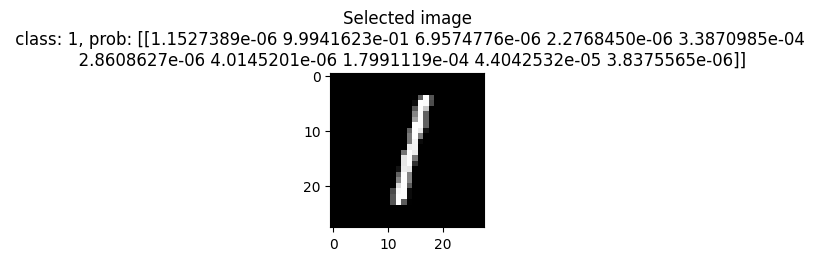

In [363]:
# Get a random test sample
x_test_sample_ind = np.random.randint(0, x_test.shape[0])
random_sample = x_test[x_test_sample_ind, ...].reshape(1, 28, 28)

original_prediction = model.predict(random_sample)
original_prediction_class = np.argmax(original_prediction)
original_prediction_probability = np.max(original_prediction)

plt.figure(figsize=(2, 2))
plt.imshow(random_sample[0], cmap=plt.get_cmap('gray'))
plt.title(f'Selected image\n class: {original_prediction_class}, prob: {original_prediction}')

#### Now that we have an image sample, we can see how the image was originally classified by our model.

#### As expected, our model correctly classifies the sample with very high confidence. Now, let’s generate an adversarial sample using this image as a starting point…

### Now, let’s generate an adversarial sample using this image as a starting point…

In [376]:
input = random_sample
target_class = 0

while True:

    input = gradient_ascend(input=input, model=model, target_class=target_class, output_class=original_prediction_class)

    updated_prediction = model.predict(input)
    updated_prediction_class = np.argmax(updated_prediction)
    updated_prediction_probability = np.max(updated_prediction)

    print(f"Current prediction: {updated_prediction_class}; Prob: {updated_prediction_probability:.2f}")

    if np.argmax(model.predict(input)) == target_class:
        break
# updated_prediction

1/1 [==============================] - 0s 26ms/step
Current prediction: 1; Prob: 0.87
1/1 [==============================] - 0s 24ms/step
Current prediction: 4; Prob: 0.84
1/1 [==============================] - 0s 27ms/step
Current prediction: 4; Prob: 1.00
1/1 [==============================] - 0s 28ms/step
Current prediction: 4; Prob: 1.00
1/1 [==============================] - 0s 23ms/step
Current prediction: 4; Prob: 1.00
1/1 [==============================] - 0s 27ms/step
Current prediction: 4; Prob: 1.00
1/1 [==============================] - 0s 23ms/step
Current prediction: 4; Prob: 1.00
1/1 [==============================] - 0s 28ms/step
Current prediction: 4; Prob: 1.00
1/1 [==============================] - 0s 30ms/step
Current prediction: 4; Prob: 1.00
1/1 [==============================] - 0s 25ms/step
Current prediction: 4; Prob: 1.00
1/1 [==============================] - 0s 23ms/step
Current prediction: 4; Prob: 1.00
1/1 [==============================] - 0s 24ms/step
Cu

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(2, 2))
plt.imshow(input[0], cmap=plt.get_cmap('gray'))
plt.title(f'Selected image, class: {updated_prediction_class}, prob: {updated_prediction_probability}')

In [ ]:
diff = abs(random_sample[0] - input[0])
# diff.shape

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].imshow(random_sample[0], cmap=plt.get_cmap('gray'))
axes[0].set_title(f'Original Image \n class: {original_prediction_class}, prob: {original_prediction_probability}')

axes[1].imshow(input[0], cmap=plt.get_cmap('gray'))
axes[1].set_title(f'Adversarial Image \n orig_class: {original_prediction_class}, prob: {updated_prediction[0][original_prediction_class]}\n class: {updated_prediction_class}, prob: {updated_prediction_probability}')

axes[2].imshow(diff, cmap=plt.get_cmap('gray'))
axes[2].set_title(f'Perturbations')